In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import functools
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [1]:
import sys
sys.path.append("..")

# import utils 
from utils.viz_tools import plot_central_cuts
from utils.data import MriSegmentation, MriClassification

In [15]:
all_data = MriClassification(sample='all', data_type = 'img', ignore_missing= False,
                         coord_min=(30,30,30,), img_shape=(192, 192, 192,),
                         image_path= '/gpfs/gpfs0/sbi/data/fcd_classification_bank',
                         targets_path= '../targets/targets_fcd_bank.csv')

  0%|          | 0/1404 [00:00<?, ?it/s]

Assembling data for:  all  sample.


100%|██████████| 1404/1404 [03:54<00:00,  5.98it/s]


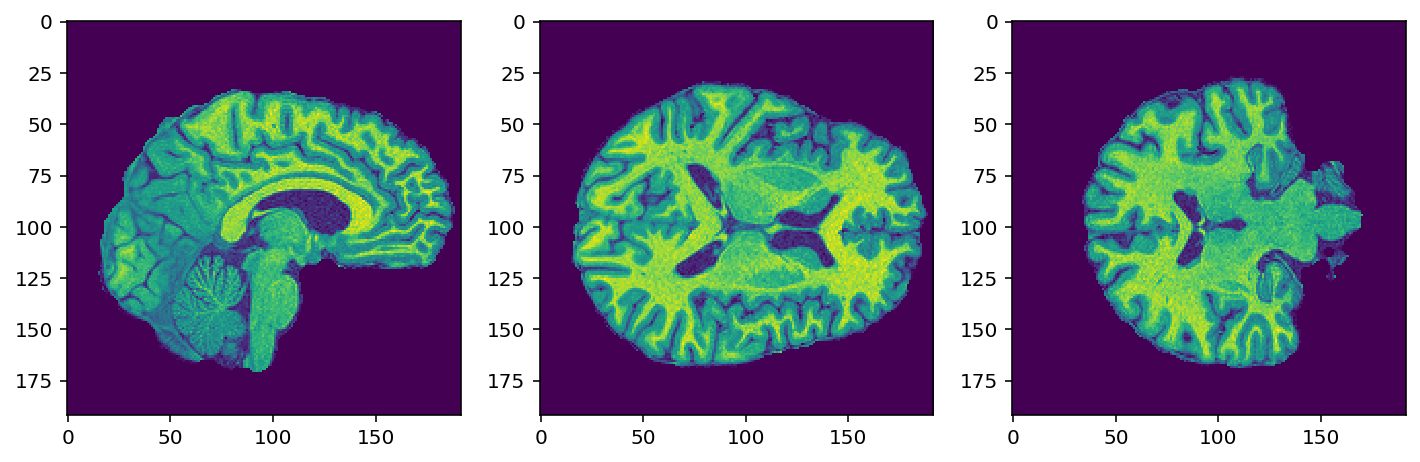

In [30]:
plot_central_cuts(all_data[40])

In [25]:
from scipy import stats

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

In [38]:
len(np.linspace(1,1400,140))

140

In [40]:
targets = pd.read_csv('../targets/targets_fcd_bank.csv')

In [42]:
targets['sample'].value_counts()

kulakov      480
hcp          441
la5_study    272
soloviev     181
pirogov       30
Name: sample, dtype: int64

In [54]:
j = all_data.scan[i]
all_data.scan_keys[j]

'3T_pirogov'

In [52]:
all_data.scan_keys

array(['1.5T_soloviev', '35343', '35426', '3T_kulakov', '3T_pirogov',
       'Q01', 'Q02', 'Q03', 'Q04', 'Q05', 'Q06', 'Q07', 'Q08', 'Q09',
       'Q10', 'Q11', 'Q12', 'Q13'], dtype=object)

In [ ]:
if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for i in tqdm(np.linspace(1,1400,140)):
        tensor = all_data[i]
        if 'kulakov' in path.name: color = 'red'
        elif 'Q' in path.name: color = 'green'
        elif '35' in path.name: color = 'blue'
        elif 'soloviev' in path.name: color = 'blue'
        elif 'pirogov' in path.name: color = 'blue'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(-100, 2000)
    ax.set_ylim(0, 0.004);
    ax.set_title('Original histograms of all samples')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None
else:
    graph = display.Image(url='https://www.dropbox.com/s/daqsg3udk61v65i/hist_original.png?dl=1')
graph

# Data

In [62]:
# LA5_study_general
la5_data = ['/home/datasets/LA5study/fmriprep_LA5study_aroma/fmriprep/']
la5_temp_npy_folder_path = 'kondrateva/pipeline_model_validation/classification_la5/DL/2019_baselines/LA5study_temp_npy/LA5study_temp_npy/' # for numpy files
la5_target_path = './LA5study_targets.csv'
#  LA5_study_smri
la5_smri_file_suffix = 'T1w_space-MNI152NLin2009cAsym_preproc.nii'
la5_smri_brain_mask_suffix = 'T1w_space-MNI152NLin2009cAsym_brainmask.nii'

In [70]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

LA5 absmax before normalization: 435.0126647949219
Dataset size: 175
Labels distribution: (array([0, 1]), array([125,  50]))

Example:
Image shape: torch.Size([1, 153, 189, 163])
Target: 0


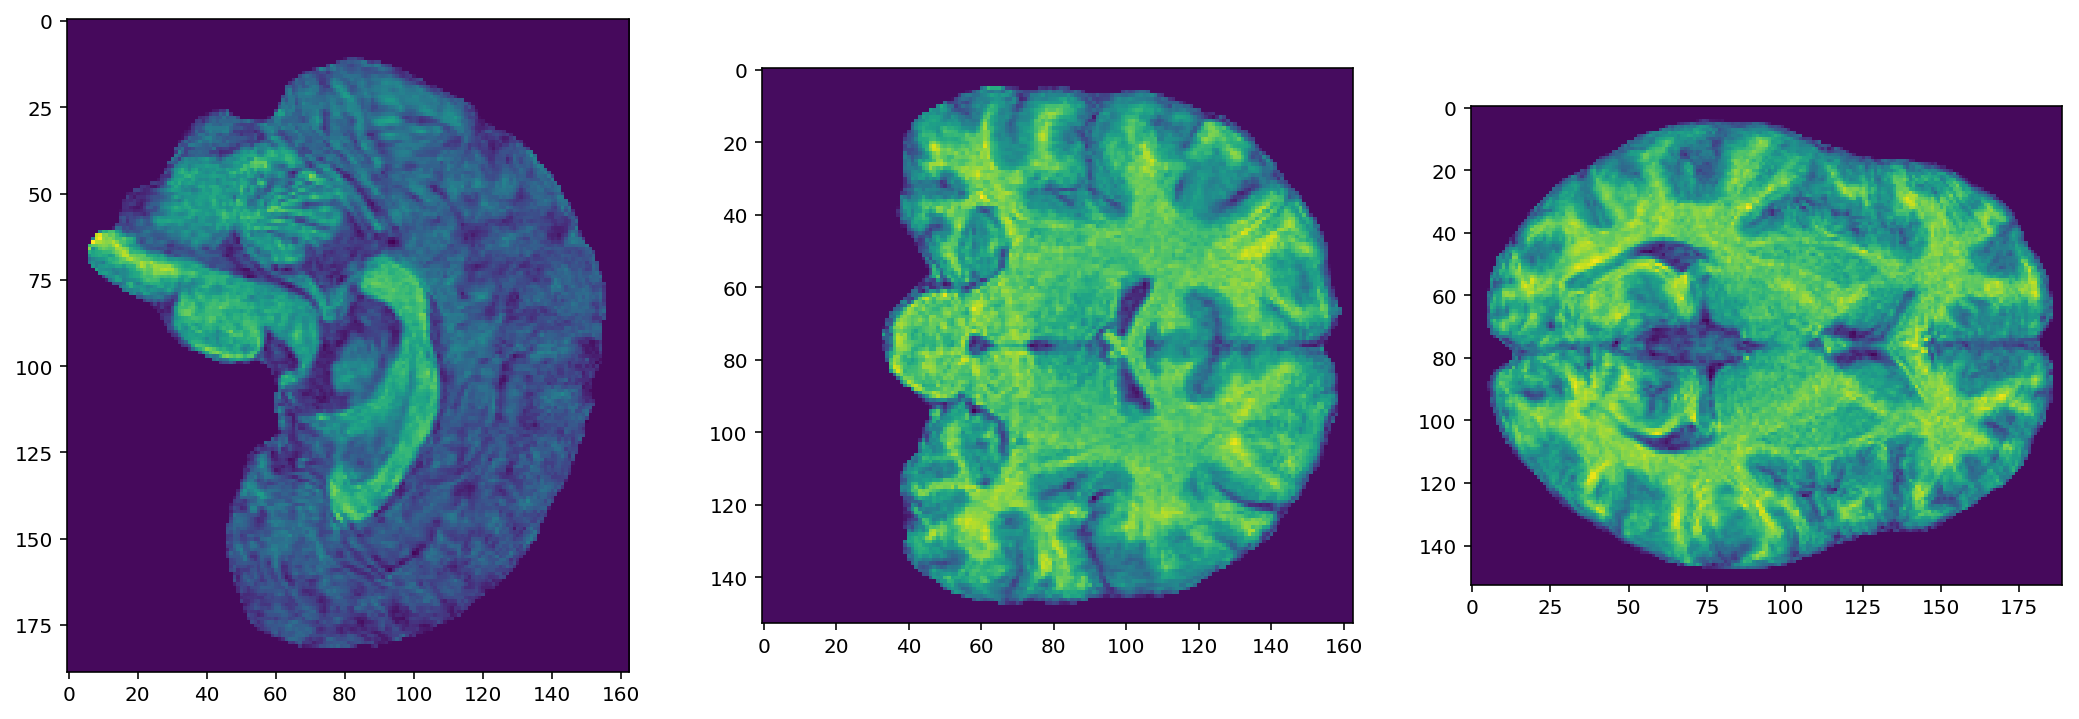

In [71]:
la5_dataset = data.LA5_Siblings_MRI(
    paths= la5_data,
    target_path= la5_target_path,
    load_online=True,
    mri_type="sMRI",
    mri_file_suffix= la5_smri_file_suffix,
    brain_mask_suffix= la5_smri_brain_mask_suffix,
    coord_min=(20,20,0),
    img_shape=(153, 189, 163),
    problems=['Schz/Control'],
    temp_storage_path= la5_temp_npy_folder_path
)
la5_absmax = 435.0126647949219 # get_absmax(la5_dataset)
la5_dataset.transform = functools.partial(AbsMaxScale, absmax=la5_absmax)

transform = transforms.Compose([
    BrightnessContrast(),
    GaussNoise(),
#     Rotate(),
#     HorizontalFlip(),
#     Gaussian_blur(),
    ToTensor(),
])
la5_dataset.transform = transform
print("LA5 absmax before normalization: {}".format(la5_absmax))
print("Dataset size: {}".format(len(la5_dataset)))
print("Labels distribution: {}\n".format(np.unique(la5_dataset.labels, return_counts=True)))

print("Example:")
img, target = la5_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img)

# Model structure

In [72]:
def create_model_opt(model_load_path=None, transfer=False):
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = models.VoxResNet(num_classes=2, n_filters=32, stride=2, n_blocks=4,
                             input_shape=la5_dataset.img_shape, dropout=0., n_fc_units=128,
                             n_flatten_units=23040)
    

    if model_load_path is not None:
        model.load_state_dict(torch.load(model_load_path))  
    if transfer:
        for param in model.parameters():
            param.requires_grad = False
        
        last = torch.nn.Linear(128, 2)
        modules = list(list(model.children())[0].children())[:-1] + [last]
        model = torch.nn.Sequential(torch.nn.Sequential(*modules))
        
        opt = torch.optim.Adam(last.parameters(), lr=3e-5)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=3e-5)
    return model, opt

# Train - LA5, Test - LA5

Epoch 10 of 10 took 60.081s
  training loss (in-iteration): 	0.004175
  validation loss: 			0.571347
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.80


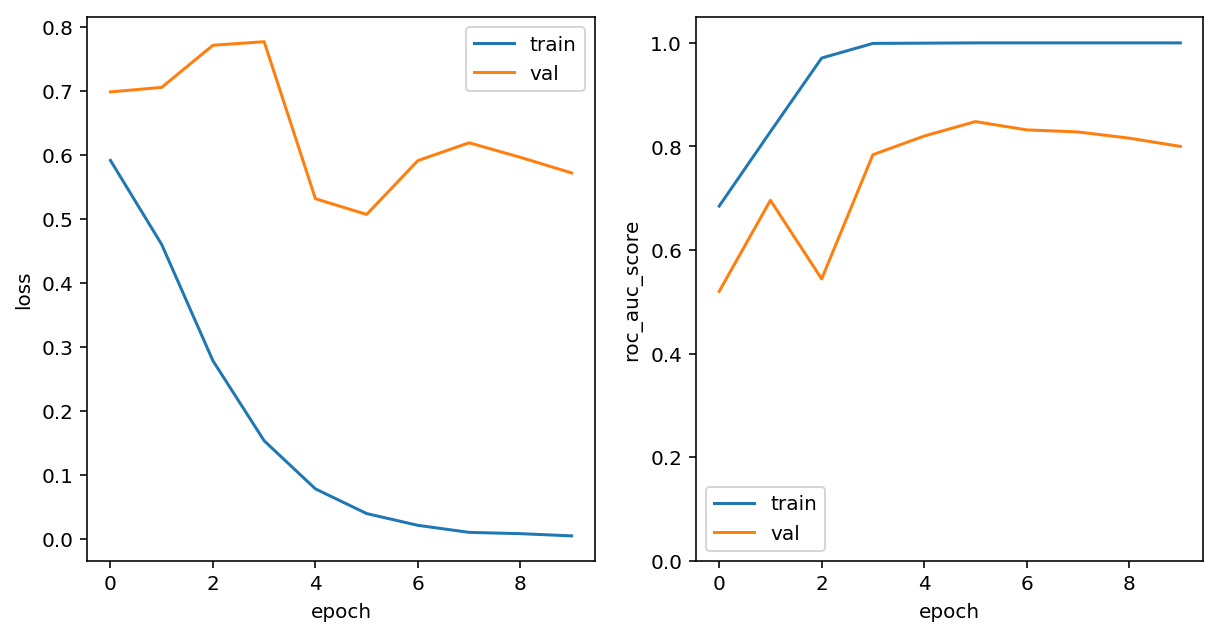

<Figure size 720x360 with 0 Axes>

val roc_auc_scores: [0.812, 0.8400000000000001, 0.6439999999999999, 0.708, 0.848]
val roc_auc_score mean: 0.7704000000000001
val roc_auc_score std: 0.08058188382012428
CPU times: user 1h 43min 20s, sys: 24min 35s, total: 2h 7min 56s
Wall time: 53min 47s


In [73]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, la5_dataset, cv, device, metric, batch_size=10)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))